In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
train_data = pd.read_csv(r"./data/train.csv")
print(train_data.info())
print('\n')
print(train_data.isna().sum())
train_data.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: in

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [3]:
def preprocess_data(data):
    data['Embarked'] = pd.factorize(data['Embarked'])[0]
    data['Sex'] = pd.factorize(data['Sex'])[0].astype(np.uint8)

    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['FareGroup'] = pd.factorize(pd.cut(data['Fare'], 
        [10, 18, 30, 60, 100, 170, 200]))[0] + 1

    # data['BoatSection'] = data['Cabin'].astype(str).str[0]

    # data['BoatSection'] = pd.factorize(data['BoatSection'])[0].astype(np.uint8) + 1

    data['Title'] = data['Name'].str.extract("([A-Za-z]+)\.", expand=False)
    data['Title'].replace(['Mlle', 'Ms', 'Lady'], 'Miss', inplace=True)
    data['Title'].replace(['Mme'], 'Mrs', inplace=True)
    data['Title'].replace(['Countess', 'Jonkheer', 'Don'], 'Royalty', inplace=True)
    data['Title'].replace(['Col', 'Major', 'Capt'], 'Military', inplace=True)
    data['Title'].replace(['Sir'], 'Mr', inplace=True)
    data['Title'] = pd.factorize(data['Title'])[0].astype(np.uint8) + 1

    data['Age'].fillna(data.groupby(['Sex', 'Pclass', 'Title'])['Age']
        .transform('mean'), inplace=True)

    data['AgeGroup'] = pd.factorize(pd.cut(data['Age'], [8, 18, 28, 40, 60]))[0] + 1

    data['LastName'] = data['Name'].str.extract('^(.+?),', expand = False)
    data['LastName'] = pd.factorize(data['LastName'])[0].astype(np.uint16)+ 1

    # data['Ticket'] = data['Ticket'].str.split().apply(lambda x: 0 if x[:][-1] == 'LINE' else x[:][-1])
    # data['Ticket'] = pd.factorize(data['Ticket'])[0].astype(np.uint32) + 1

    return data

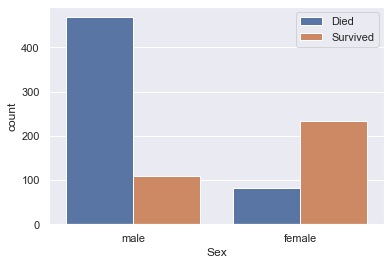

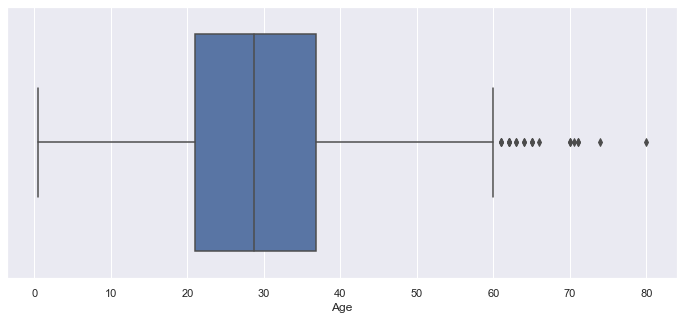

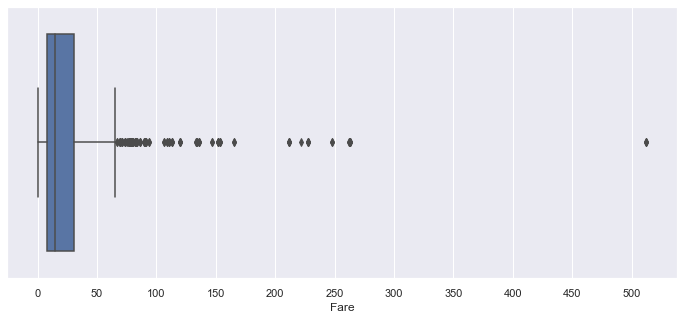

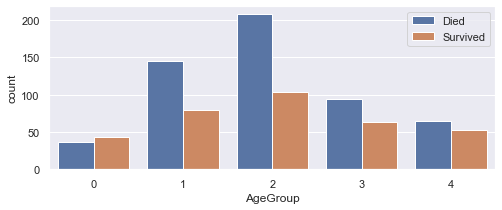

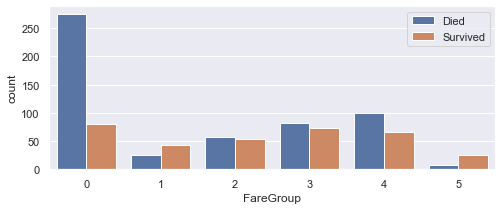

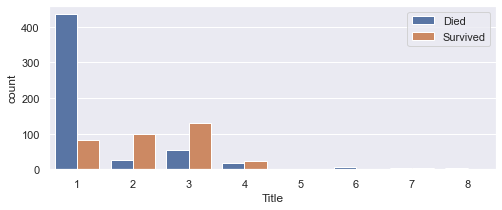

<AxesSubplot:>

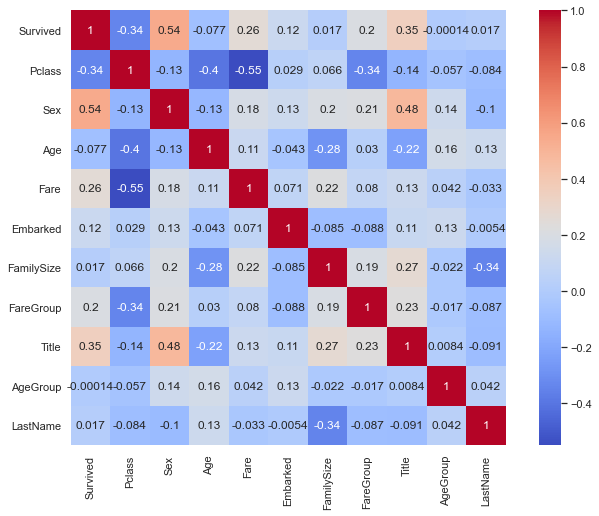

In [4]:
sns.countplot(x="Sex", hue="Survived", data=train_data)
plt.legend(['Died', 'Survived'])
plt.show()

train_data = preprocess_data(train_data)
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_data['Age'])

train_data = preprocess_data(train_data)

plt.figure(figsize=(12, 5))
plt.xticks(np.arange(0, 550, step=50))
sns.boxplot(x=train_data['Fare'])

plt.figure(figsize=(8,3))
sns.countplot(x="AgeGroup", hue="Survived", data=train_data)
plt.legend(['Died', 'Survived'])
plt.show()

plt.figure(figsize=(8,3))
sns.countplot(x="FareGroup", hue="Survived", data=train_data)
plt.legend(['Died', 'Survived'])
plt.show()

plt.figure(figsize=(8,3))
sns.countplot(x="Title", hue="Survived", data=train_data)
plt.legend(['Died', 'Survived'])
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(train_data.drop(columns=['PassengerId', 'SibSp', 'Parch']).corr(), annot=True, square=True, cmap='coolwarm')
    

In [5]:
shuffled_data = train_data.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']).sample(frac=1)
s_types = {'PassengerId': np.uint16, 'Pclass': np.uint8, 'Sex': np.uint8, 'Age': np.float32, 'Fare': np.float32, 'Embarked': np.uint8, 'FamilySize': np.uint8, 'FareGroup': np.uint8, 'Title': np.uint8, 'AgeGroup': np.uint8}

shuffled_data = shuffled_data.astype(s_types)

train_index = int(891 * .8)

train_X = shuffled_data.iloc[:train_index, :].drop(columns=['Survived'])
train_y = shuffled_data.iloc[:train_index, :]['Survived']
val_X = shuffled_data.iloc[train_index:, :].drop(columns=['Survived'])
val_y = shuffled_data.iloc[train_index:, :]['Survived']
all_X = shuffled_data.drop(columns=['Survived'])
all_y = shuffled_data['Survived']

print(train_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 471 to 363
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    uint16 
 1   Pclass       712 non-null    uint8  
 2   Sex          712 non-null    uint8  
 3   Age          712 non-null    float32
 4   Fare         712 non-null    float32
 5   Embarked     712 non-null    uint8  
 6   FamilySize   712 non-null    uint8  
 7   FareGroup    712 non-null    uint8  
 8   Title        712 non-null    uint8  
 9   AgeGroup     712 non-null    uint8  
 10  LastName     712 non-null    uint16 
dtypes: float32(2), uint16(2), uint8(7)
memory usage: 18.8 KB
None


In [6]:
model = xgb.XGBClassifier(
    max_depth=4,
    n_estimators=80,
    min_child_weight=.5, 
    colsample_bytree=.7, 
    subsample=0.7, 
    sampling_method='uniform',
    eta=0.1,
    tree_method='gpu_hist',
    max_bin = 256,
    seed=42,
    use_label_encoder=False,
    n_jobs=-1)

eval_metric = 'error'

# parameters = {
# 'subsample': np.arange(.1, 1, .1),
# 'sampling_method': ['uniform', 'gradient_based']}


# grid = GridSearchCV(model, parameters, n_jobs=-1, scoring='accuracy', verbose=2)
# grid.fit(all_X, all_y)

# print(grid.best_params_)

model.fit(
    all_X, 
    all_y, 
    eval_metric=eval_metric, 
    eval_set=[(train_X, train_y),(val_X, val_y)], 
    verbose=True
    )

[0]	validation_0-error:0.18820	validation_1-error:0.17877
[1]	validation_0-error:0.16152	validation_1-error:0.15084
[2]	validation_0-error:0.16152	validation_1-error:0.13967
[3]	validation_0-error:0.16433	validation_1-error:0.11173
[4]	validation_0-error:0.15028	validation_1-error:0.10615
[5]	validation_0-error:0.15590	validation_1-error:0.10615
[6]	validation_0-error:0.15168	validation_1-error:0.11732
[7]	validation_0-error:0.15871	validation_1-error:0.11732
[8]	validation_0-error:0.15590	validation_1-error:0.11732
[9]	validation_0-error:0.15730	validation_1-error:0.11732
[10]	validation_0-error:0.15309	validation_1-error:0.11173
[11]	validation_0-error:0.15028	validation_1-error:0.11732
[12]	validation_0-error:0.15309	validation_1-error:0.11732
[13]	validation_0-error:0.15590	validation_1-error:0.11173
[14]	validation_0-error:0.15449	validation_1-error:0.11173
[15]	validation_0-error:0.15028	validation_1-error:0.10056
[16]	validation_0-error:0.15028	validation_1-error:0.10056
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.1, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_delta_step=0,
              max_depth=4, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              sampling_method='uniform', scale_pos_weight=1, seed=42,
              subsample=0.7, tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, ...)

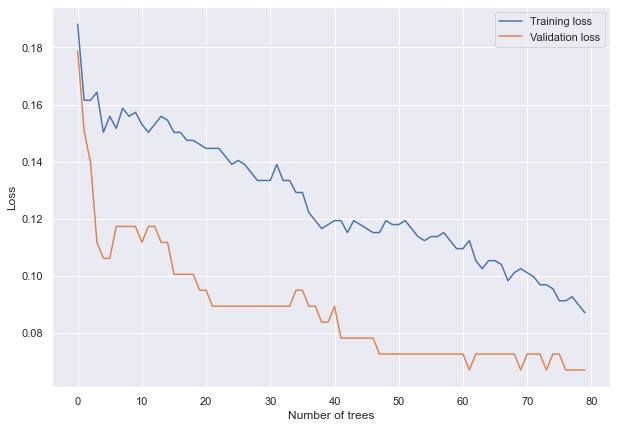

In [7]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][eval_metric], label="Training loss")
plt.plot(results["validation_1"][eval_metric], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [8]:
test_df = pd.read_csv("./data/test.csv")
test_df = preprocess_data(test_df).drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'])
print(test_df.info())
predictions = model.predict(test_df)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": predictions})

print(submission.info())
submission.to_csv('submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    uint8  
 3   Age          418 non-null    float64
 4   Fare         417 non-null    float64
 5   Embarked     418 non-null    int64  
 6   FamilySize   418 non-null    int64  
 7   FareGroup    418 non-null    int64  
 8   Title        418 non-null    uint8  
 9   AgeGroup     418 non-null    int64  
 10  LastName     418 non-null    uint16 
dtypes: float64(2), int64(6), uint16(1), uint8(2)
memory usage: 27.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int32
dtypes: 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

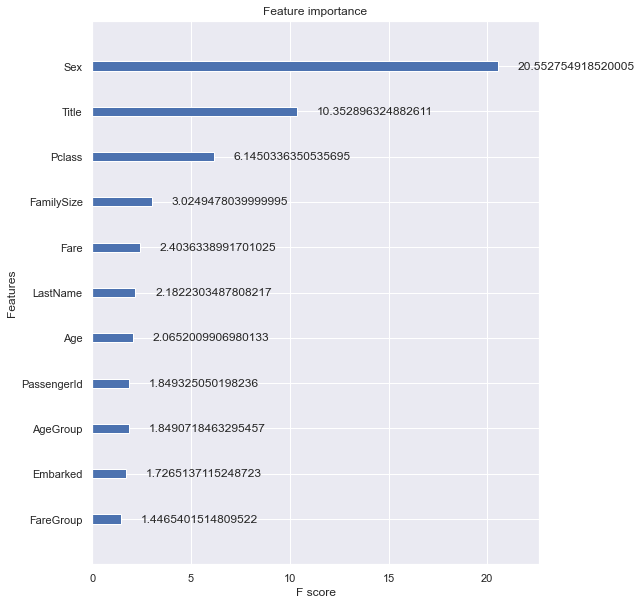

In [9]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, importance_type='gain')

plot_features(model, (8,10))